# Leaf Disease Identification in Apple Trees 

In [1]:
# Import Libraries

from __future__ import print_function
from __future__ import division

# PyTorch for Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset,DataLoader

# Matplotlib for plots
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Opencv
import  cv2

# Sklearn for ML
from sklearn.model_selection import train_test_split # To split the data in training and validation
from sklearn.metrics import roc_auc_score

# NumPy for Linear Algebra
import numpy as np

# Pandas for data processing
import pandas as pd

from tqdm.notebook import tqdm
import time
import copy
import os

# To check th PyTorch Version
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
torch.manual_seed(42)

PyTorch Version:  1.11.0
Torchvision Version:  0.12.0


In [2]:
# Get directory, and image files path
for  dirpath, dirname, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirpath, filename))


/kaggle/input/apple-disease/sample_submission.csv
/kaggle/input/apple-disease/train.csv
/kaggle/input/apple-disease/test.csv
/kaggle/input/apple-disease/images/Test_1743.jpg
/kaggle/input/apple-disease/images/Test_262.jpg
/kaggle/input/apple-disease/images/Train_1524.jpg
/kaggle/input/apple-disease/images/Train_1336.jpg
/kaggle/input/apple-disease/images/Train_1461.jpg
/kaggle/input/apple-disease/images/Train_1797.jpg
/kaggle/input/apple-disease/images/Test_1499.jpg
/kaggle/input/apple-disease/images/Train_1170.jpg
/kaggle/input/apple-disease/images/Test_1259.jpg
/kaggle/input/apple-disease/images/Test_422.jpg
/kaggle/input/apple-disease/images/Test_636.jpg
/kaggle/input/apple-disease/images/Test_1395.jpg
/kaggle/input/apple-disease/images/Test_1800.jpg
/kaggle/input/apple-disease/images/Train_92.jpg
/kaggle/input/apple-disease/images/Train_966.jpg
/kaggle/input/apple-disease/images/Train_231.jpg
/kaggle/input/apple-disease/images/Test_1391.jpg
/kaggle/input/apple-disease/images/Test_8

## Data Processing

### Data Visualisation

In [3]:
DIR_INPUT = '../input/apple-disease' # Input Directory
Data_dir = "../input/apple-disease/images" # Data directory which contains images for training and testing

df = pd.read_csv("../input/apple-disease/train.csv") # Convert "train.csv" to dataframe, for training 
test_df = pd.read_csv("../input/apple-disease/test.csv") # Convert "test.csv" to dataframe, for testing

In [4]:
# Type of diseases in the dataset
print(f'The name of the columns in the dataset:  {df.columns}')

The name of the columns in the dataset:  Index(['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')


In [5]:
# Healthy leaves
healthy_leaves = df[df['healthy']==1]
print(f'The total number of healthy leaves in the training data: {healthy_leaves.shape[0]}')

# Leaves with rust disease
rust_leaves = df[df['rust']==1]
print(f'The total number of leaves with rust disease in the training data: {rust_leaves.shape[0]}')

# Leaves with scab disease
scab_leaves = df[df['scab']==1]
print(f'The total number of leaves with rust disease in the training data: {scab_leaves.shape[0]}')

# Leaves with multiple disease
mdiseases_leaves = df[df['multiple_diseases']==1]
print(f'The total number of leaves with multiple diseases in the training data: {mdiseases_leaves.shape[0]}')

The total number of healthy leaves in the training data: 516
The total number of leaves with rust disease in the training data: 622
The total number of leaves with rust disease in the training data: 592
The total number of leaves with multiple diseases in the training data: 91


In [6]:
# Convert the 'imageid' extension to 'jpg' format
df['image_id']+='.jpg'
test_df['image_id']+='.jpg'

#### Images from the Training Dataset

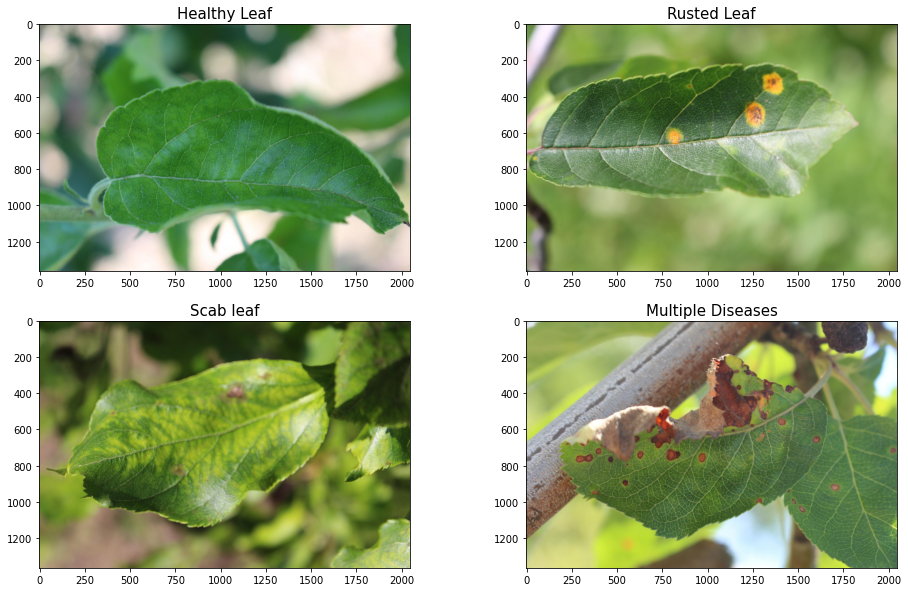

In [7]:
# Visualisation of different leaf diseases in the datset
im_healthy = plt.imread('../input/apple-disease/images/Train_2.jpg', format = 'jpg')# Read the image from the image path
im_scab = plt.imread('../input/apple-disease/images/Train_0.jpg', format = 'jpg')
im_mdiseases = plt.imread('../input/apple-disease/images/Train_1.jpg', format = 'jpg')
im_rust = plt.imread('../input/apple-disease/images/Train_3.jpg', format = 'jpg')

fig = plt.figure(figsize=(16,10))
# Healthy Leaf
ax = fig.add_subplot(2,2,1)
ax.set_title('Healthy Leaf', fontsize = 15)
ax.imshow(im_healthy) # Show the image

# Rusted Leaf
ax = fig.add_subplot(2,2,2)
ax.set_title('Rusted Leaf', fontsize = 15)
ax.imshow(im_rust) # Show the image

# Scab Leaf
ax = fig.add_subplot(2,2,3)
ax.set_title('Scab leaf', fontsize = 15)
ax.imshow(im_scab) # Show the image

# Multiple Diseases
ax = fig.add_subplot(2,2,4)
ax.set_title('Multiple Diseases', fontsize = 15)
ax.imshow(im_mdiseases) # Show the image

In [8]:
# Defining the labels and class for each category
label = df.loc[:, 'healthy':'scab']   #Using loc function function from pandas library
#print(label)

label = label.values # Converting them to array for a particular image with that class
#print(label)

# We are creating a column name as 'class' which describes the category of class with that belongs to

x = np.argmax(label,axis=1) # Identifies the maximum value for every row and returns the column index of that maximum value
print(x.shape)
df['class'] = x
print(df)

(1821,)
            image_id  healthy  multiple_diseases  rust  scab  class
0        Train_0.jpg        0                  0     0     1      3
1        Train_1.jpg        0                  1     0     0      1
2        Train_2.jpg        1                  0     0     0      0
3        Train_3.jpg        0                  0     1     0      2
4        Train_4.jpg        1                  0     0     0      0
...              ...      ...                ...   ...   ...    ...
1816  Train_1816.jpg        0                  0     0     1      3
1817  Train_1817.jpg        1                  0     0     0      0
1818  Train_1818.jpg        1                  0     0     0      0
1819  Train_1819.jpg        0                  0     1     0      2
1820  Train_1820.jpg        0                  0     0     1      3

[1821 rows x 6 columns]


#### Splitting of 'df ' into training, validation dataframe

This **Stratify Parameter** makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.

For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.

In [9]:
# Splitting the dataframe and resetting the index for each splitted dataframe
train_df, valid_df = train_test_split(df,test_size=0.2,shuffle=True,stratify=df['class'])# Splitting into 80%training, 20% validation
train_label = train_df.loc[:, 'healthy':'scab']
valid_label = valid_df.loc[:,'healthy':'scab']

train_df.reset_index(drop=True,inplace=True) 
train_label.reset_index(drop=True,inplace=True)
valid_df.reset_index(drop=True,inplace=True)
valid_label.reset_index(drop=True,inplace=True)

In [10]:
# Trainig and valid dataframe after splititng
print(train_df.head())
print(f'The total number of training images for the model: {train_df.shape[0]}')

         image_id  healthy  multiple_diseases  rust  scab  class
0   Train_999.jpg        0                  0     1     0      2
1  Train_1817.jpg        1                  0     0     0      0
2  Train_1520.jpg        0                  0     0     1      3
3   Train_950.jpg        0                  0     1     0      2
4  Train_1451.jpg        0                  0     1     0      2
The total number of training images for the model: 1456


### Creating Own Customised Dataset by resizing the image, and transform

In [11]:
class Plant_dataset(Dataset):
    
    def __init__(self,df,data_dir,transform,train=True,label=None):
        self.len = df.shape[0]
        self.dir = data_dir
        self.transform=transform
        self.df = df
        self.train=train
        self.label=label
        
    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        img_pth = os.path.join(self.dir,self.df['image_id'].loc[idx])
        image = mpimg.imread(img_pth)
        image = cv2.resize(image,(224,224)) #resizing the image to 224x224 pixel and transforming it 
        if self.transform:
            image = self.transform(image)
        if(self.train==True):
            labels = np.argmax(self.label.loc[idx,:].values)
        else:
            return image
        return image,labels
    

In [12]:
# Given mean, and standard deviation for 3 channels, with Imagenet statistics
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

# For transformations there is a need to convert image to PIL IMAGE format, and tensor because most transformations accept PIL Image and Tensor

# Converting Image to PIL Image
train_transf = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor(),normalize])
valid_transf = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),normalize])
test_transf = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),normalize])

In [13]:
# Dataset  for training, validaton and testing after doing transformations

train_dataset = Plant_dataset(train_df,Data_dir,transform=train_transf,train=True,label=train_label)
valid_dataset = Plant_dataset(valid_df,Data_dir,transform=valid_transf,train=True,label=valid_label)
test_dataset = Plant_dataset(test_df,Data_dir,transform=test_transf,train=False)

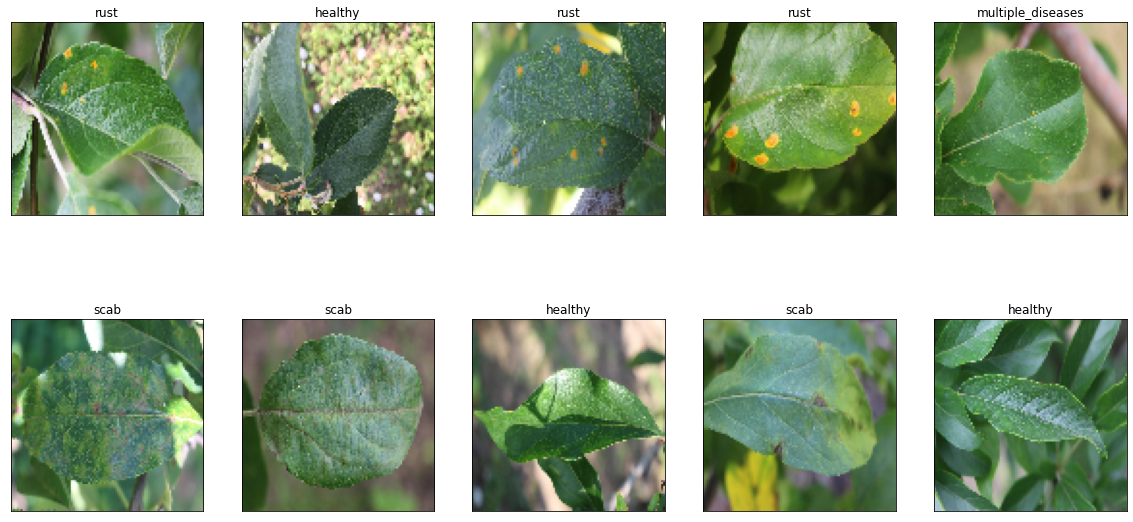

In [14]:
# Actual data that we are feeding to the model for training
col = train_df.columns
fig = plt.figure(figsize=(20, 10))
for i, idx in enumerate(np.random.choice(train_df.index, 10)):
    ax = fig.add_subplot(2, 10//2, i+1, xticks=[], yticks=[])
    pth = os.path.join(Data_dir,train_df.image_id[idx])
    im = mpimg.imread(pth)
    im = cv2.resize(im, (100, 100)) 
    plt.imshow(im, cmap="hot")
    lab =col[np.argmax(train_df.loc[idx, ['healthy', 'multiple_diseases', 'rust', 'scab']].values)+1]
    ax.set_title(lab)

### Defining Dataloaders from the DataLoader class

In [15]:
# Creating dataloaders for training, validation and test
batch_size=32 

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(dataset=valid_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size)

dataloaders_dict ={'train':train_loader,'val':val_loader}

## Models defining

In [16]:
# Choose the model

model_name = "resnet"
num_classes = 4
num_epochs = 10 
feature_extract = False # we are using pretrained weights
learning_rate = 0.0008  # used the fixed learning rate for each architecture

In [17]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [18]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [19]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "resnext":
        """ Resnext50_32x4d
        """
        model_ft = models.resnext50_32x4d(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "densenet201":
        """ Densenet201
        """
        model_ft = models.densenet201(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
# Send the model to GPU
model_ft = model_ft.to(device)

In [22]:
##Print all the trainable layer 
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [23]:
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=10, is_inception=(model_name=="inception"))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9
----------
train Loss: 0.5588 Acc: 0.8269
val Loss: 1.0491 Acc: 0.7507

Epoch 1/9
----------
train Loss: 0.2580 Acc: 0.9176
val Loss: 0.3451 Acc: 0.9041

Epoch 2/9
----------
train Loss: 0.1623 Acc: 0.9416
val Loss: 0.3171 Acc: 0.9205

Epoch 3/9
----------
train Loss: 0.1466 Acc: 0.9560
val Loss: 0.3574 Acc: 0.9014

Epoch 4/9
----------
train Loss: 0.1039 Acc: 0.9622
val Loss: 0.5038 Acc: 0.8575

Epoch 5/9
----------
train Loss: 0.1765 Acc: 0.9416
val Loss: 0.4878 Acc: 0.8466

Epoch 6/9
----------
train Loss: 0.0945 Acc: 0.9670
val Loss: 0.2665 Acc: 0.9288

Epoch 7/9
----------
train Loss: 0.0434 Acc: 0.9828
val Loss: 0.3984 Acc: 0.9096

Epoch 8/9
----------
train Loss: 0.0788 Acc: 0.9718
val Loss: 0.4046 Acc: 0.8822

Epoch 9/9
----------
train Loss: 0.0500 Acc: 0.9849
val Loss: 0.4940 Acc: 0.8493

Training complete in 12m 20s
Best val Acc: 0.928767


## Prediction on test dataset

In [24]:
# Defining a fuction for making prediction on the test dataset

def prediction(model,dataloader):
    model.eval()
    test_preds = None
    for i,batch in enumerate(dataloader):
        image = batch
        image = image.to(device)
        with torch.no_grad():
            out = model(image)
            if test_preds is None:
                test_preds = out.data.cpu()
            else:
                test_preds = torch.cat((test_preds, out.data.cpu()), dim=0)
    return test_preds

In [25]:
# Making prediction on test dataset using our trained model and passing it as argument for prediction()
test_pred = prediction(model_ft,test_loader)

In [26]:
# Let's see the predictions made by our model on each test image
print('prediction',test_pred)

prediction tensor([[-6.1516,  1.0406,  7.7677, -5.8886],
        [-5.2775, -0.2678,  8.9336, -6.6940],
        [-5.4475,  0.2056, -4.5821,  7.4441],
        ...,
        [-6.6347, -1.4692, 12.3608, -8.2752],
        [ 6.7589, -2.3558, -2.4609, -2.8999],
        [-2.0529,  0.5757, -2.1552,  2.5611]])


In [27]:
test_pred_nparr = test_pred.cpu().detach().numpy()

In [28]:
# Making result dataframe to view the predictions
result_df = pd.read_csv(DIR_INPUT + '/sample_submission.csv')
result_df.iloc[:, 1:] = 0

In [29]:
# Using softmax() to predict between the desired diseases in a leaf
result_df[['healthy', 'multiple_diseases', 'rust', 'scab']] = torch.softmax(test_pred, dim=1) 
result_df.to_csv('submission.csv', index=False)

In [30]:
result_df# Final dataframe predicted by our model on test dataset images

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,tensor(9.0034e-07),tensor(0.0012),tensor(0.9988),tensor(1.1712e-06)
1,Test_1,tensor(6.7322e-07),tensor(0.0001),tensor(0.9999),tensor(1.6328e-07)
2,Test_2,tensor(2.5173e-06),tensor(0.0007),tensor(5.9812e-06),tensor(0.9993)
3,Test_3,tensor(0.9999),tensor(2.9982e-05),tensor(4.7504e-05),tensor(3.5146e-05)
4,Test_4,tensor(2.0642e-09),tensor(5.4804e-05),tensor(0.9999),tensor(1.4663e-09)
...,...,...,...,...,...
1816,Test_1816,tensor(1.8358e-18),tensor(5.8171e-11),tensor(1.),tensor(2.9841e-19)
1817,Test_1817,tensor(0.1196),tensor(0.6574),tensor(0.0459),tensor(0.1771)
1818,Test_1818,tensor(5.6283e-09),tensor(9.8566e-07),tensor(1.0000),tensor(1.0911e-09)
1819,Test_1819,tensor(0.9997),tensor(0.0001),tensor(9.9030e-05),tensor(6.3840e-05)


Text(0.5, 1.0, 'Test_4')

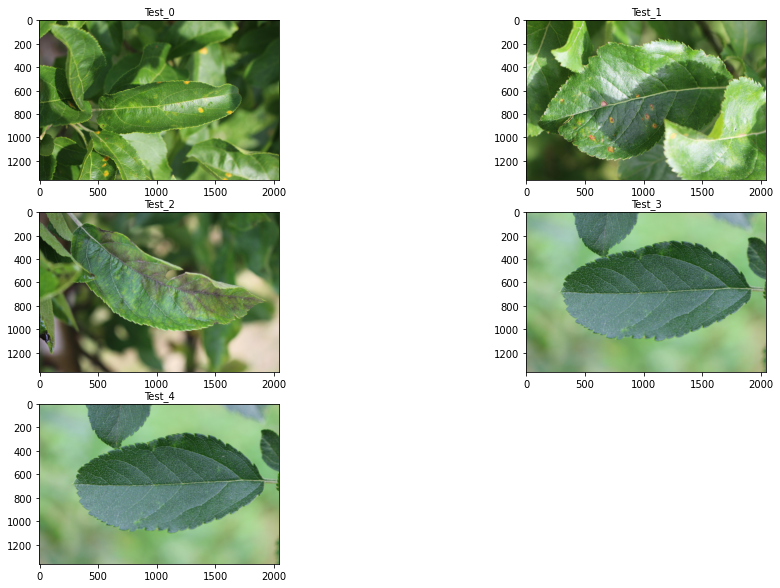

In [31]:
# Plotting some of the images from test dataset to visualise the prediction using result_df
im_result0 = plt.imread('../input/apple-disease/images/Test_0.jpg', format = 'jpg')
im_result1 = plt.imread('../input/apple-disease/images/Test_1.jpg', format = 'jpg')
im_result2 = plt.imread('../input/apple-disease/images/Test_2.jpg', format = 'jpg')
im_result3 = plt.imread('../input/apple-disease/images/Test_3.jpg', format = 'jpg')
im_result4 = plt.imread('../input/apple-disease/images/Test_4.jpg', format = 'jpg')


fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(im_result0)
ax.set_title('Test_0', fontsize = 10)

ax = fig.add_subplot(3, 2, 2)
ax.imshow(im_result1)
ax.set_title('Test_1', fontsize = 10)


ax = fig.add_subplot(3, 2, 3)
ax.imshow(im_result2)
ax.set_title('Test_2', fontsize = 10)

ax = fig.add_subplot(3, 2, 4)
ax.imshow(im_result3)
ax.set_title('Test_3', fontsize = 10)

ax = fig.add_subplot(3, 2, 5)
ax.imshow(im_result3)
ax.set_title('Test_4', fontsize = 10)